<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Статистика-обращений-во-внутреннюю-техническую-поддержку" data-toc-modified-id="Статистика-обращений-во-внутреннюю-техническую-поддержку-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Статистика обращений во внутреннюю техническую поддержку</a></span><ul class="toc-item"><li><span><a href="#Получение-данных" data-toc-modified-id="Получение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Получение данных</a></span><ul class="toc-item"><li><span><a href="#Авторизация" data-toc-modified-id="Авторизация-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Авторизация</a></span></li><li><span><a href="#Получение-реестра-задач-по-форме" data-toc-modified-id="Получение-реестра-задач-по-форме-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Получение реестра задач по форме</a></span></li></ul></li><li><span><a href="#Преобразование-JSON-в-DataFrame" data-toc-modified-id="Преобразование-JSON-в-DataFrame-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Преобразование JSON в DataFrame</a></span><ul class="toc-item"><li><span><a href="#Описание-структуры-данных" data-toc-modified-id="Описание-структуры-данных-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Описание структуры данных</a></span></li><li><span><a href="#Преобразование-в-DF" data-toc-modified-id="Преобразование-в-DF-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Преобразование в DF</a></span></li></ul></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предобработка</a></span><ul class="toc-item"><li><span><a href="#Получение-фрейма-из-сырых-данных" data-toc-modified-id="Получение-фрейма-из-сырых-данных-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Получение фрейма из сырых данных</a></span></li><li><span><a href="#Очистка-и-подготовка-данных" data-toc-modified-id="Очистка-и-подготовка-данных-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Очистка и подготовка данных</a></span></li></ul></li><li><span><a href="#Распределения-данных" data-toc-modified-id="Распределения-данных-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Распределения данных</a></span><ul class="toc-item"><li><span><a href="#Количество-закрытых-заявок" data-toc-modified-id="Количество-закрытых-заявок-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Количество закрытых заявок</a></span></li><li><span><a href="#Распределение-заявок-по-подразделениям-(инициаторам)" data-toc-modified-id="Распределение-заявок-по-подразделениям-(инициаторам)-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Распределение заявок по подразделениям (инициаторам)</a></span></li><li><span><a href="#Среднее-время-решения-заявок" data-toc-modified-id="Среднее-время-решения-заявок-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Среднее время решения заявок</a></span></li><li><span><a href="#Распределение-баз-1С" data-toc-modified-id="Распределение-баз-1С-1.4.4"><span class="toc-item-num">1.4.4&nbsp;&nbsp;</span>Распределение баз 1С</a></span></li></ul></li></ul></li></ul></div>

# Статистика обращений во внутреннюю техническую поддержку

Задача:  

- Настроить автоматизированную выгрузку реестра задач по форме `IT` из Pyrus, используя API Pyrus;
- Подготовить данные для формирования сравнительной статистики по задачам. Сравнивается текущая неделя с предыдущей;

<!-- Ссылка на форму:  
https://pyrus.com/t#uf1224157 -->

В этом файле содержатся функции:
- для выгрузки реестра заявок по форме IT в Pyrus;
- для преобразования полученного JSON-объекта в DataFrame pandas;  

Во второй части содержатся функции для визуализации распределений:  
- по типу проблемы, указанной в обращении;
- по базам 1С;
- по среднему времени обработки обращений;  

Выводов нет, т.к. функции в этом файле предназначены только для сбора еженедельной статистики и сохранения данных.

В файле содержится код функций и описание логики.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
import datetime as dt
from datetime import date
from datetime import timedelta
import requests as rq
import ast as ast
import json

## Получение данных

### Авторизация

У Pyrus есть API, который позволяет наладить обмен данными.  

Для авторизации требуется логин и секретный ключ действующего пользователя, который можно получить в профиле. Сейчас для выгрузки данных использую действующую учетку пользователя, логин и секретный ключ записаны в файл, который хранится на локальном диске.

В идеале для выгрузки данных нужно создать бота в Pyrus, у которого будет собственный логин и секретный ключ. У бота должны быть права администратора.

In [2]:
def authorization(url, headers, login):
    '''
    Принимает на вход адрес страницы, параметры запроса и данные для авторизации,
    Отправляет POST-запрос с полученными параметрами, выводит ответный статус страницы
    При запросе возвращается access_token, который сохраняется в переменную response
    '''
    
    def get_login(file_name):
        '''
        Получает логин и секретный ключ из файла, который хранится на локальном диске
        На вход принимает имя файла, на выходе возвращает объект с логином и секретным ключом в формате JSON
        '''
        
        global login # задаем глобальную переменную
        login = open(file_name, 'r')
        login = login.read() # читаем из файла логин и секретный ключ для авторизации в Pyrus
        login = eval(login) # преобразовываем в нужный формат
        return login
    
#     отправляем запрос и выводим статус страницы
#     global response
    response = rq.post(url, headers=headers, json=get_login(file_name))
    print(f'Статус страницы:{response}')
    return response

In [3]:
# пустая переменная для логина и ключа, функция запишет в нее данные
login = {}

In [4]:
# путь к файлу с данными для авторизации (если расположение отличается от корневой папки, прописываем путь полностью)
file_name = 'pyrus_authorization.txt'

In [5]:
# адрес для авторизации
url = 'https://api.pyrus.com/v4/auth'

In [6]:
# параметры запроса
headers = {
    'Content-Type': 'application/json',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',
}

Вызываем функцию authorization с указанными параметрами

In [7]:
# вызываем функцию authorization с указанными параметрами
response = authorization(url, headers, login)

Статус страницы:<Response [200]>


Статус 200 - все параметры верны, страница доступна, авторизация прошла успешно.

### Получение реестра задач по форме

Получить реестр задач можно с помощью метода `GET/forms/register`.

Для того, чтобы получать все задачи: и открытые, и закрытые, нужно прописать параметр `&include_archived=y` в адресе ссылки на реестр. Если не указать этот параметр, по умолчанию будут выгружены только открытые задачи.

При авторизации Pyrus присылает в ответ строку, которая содержит токен авторизации `access token`, который нужно передавать при каждом запросе в формате `Authorization: Bearer access_token`. 

Токен возвращается в формате `'access_token': 'значение'`, поэтому для передачи его в качестве параметра нужно разбить строку и выделить только значение токена.

In [8]:
# прописываем адрес нужного реестра, включая архивные задачи
register_url = 'https://api.pyrus.com/v4/forms/1224157/register?&include_archived=y'

In [9]:
def get_register(register_url, response):
    '''
    Получает на вход адрес реестра задач по форме и токен авторизации,
    Отправляет запрос по указанному адресу и загружает JSON-объект в переменную
    '''
    
#     разбиваем строку с токеном и оставляем только значение без ключа (только сам токен)
    access_token = ast.literal_eval(response.text)['access_token']
    
#     задаем ключ авторизации
    bearer = 'Bearer ' + access_token
#     задаем параметры запроса
    headers = {
        'Content-Type': 'application/json',
        'Authorization': bearer
    }
    
#     запрашиваем реестр задач по форме
    register = rq.get(register_url, headers=headers)
#     выводим статус ответа страницы
    print(f'Статус страницы: {register}')
    
#     загружаем полученный JSON-объект в переменную jdata
    jdata = json.loads(register.text)
    return jdata

Вызываем функцию `get_register` и получаем реестр:

In [10]:
# вызываем функцию `get_register` и получаем реестр
jdata = get_register(register_url, response)

Статус страницы: <Response [200]>


In [11]:
# jdata

## Преобразование JSON в DataFrame

### Описание структуры данных

Объект `JSON` имеет сильно вложенную структуру:  

1. Основной массив данных `tasks` - это список задач;

2. Каждая задача содержит набор системных полей `id`, `create_date`, `last_modified_date`, `last_note_id`, `current_step`;  

3. Список `fields` содержит набор пользовательских полей, то есть тех, которые были добавлены в форму помимо системных по умолчанию. Они содержат атрибуты поля, таких как тип, описание поля, указанное в нем значение и т.д. Если это было поле без настроек видимости то его можно развернуть уже на этом этапе. К таким полям в форме относятся поля типа `Справочник`:  
    - Эл.почта инициатора;
    - Подразделение;
    - Статус заявки (мы не используем системные статусы Pyrus);
    - Исполнитель;

4. Следующий уровень вложенности возникает из-за настроек видимости полей в самой форме. Например, поле с конкретной базой 1С становится видимым только в том случае, если в предыдущем поле было выбрано "1С". Таких полей у нас пять:  
    - база;
    - услуга (мобильная связь);
    - ресурс (запрос доступа);
    - оборудование (запрос оборудования или поломка);
    - ПО (офисные программы, кроме 1С)  

Все эти поля типа `Выбор`, они содержат также набор доступных для выбора вариантов и другую техническую информацию, которая также идет вложенным списком. Разворачивать данные до такого уровня не требуется.

### Преобразование в DF

Используем функцию, которая примет на вход структурированный `JSON`, а на выходе выдаст `DataFrame`.

На первом этапе сглаживаем данные, в качестве пути к объекту указываем первый уровень `tasks`. Если не указать его, то получим датафрейм, где в каждой строке будет список записей по каждой задаче строкой.

Таким способом можно получить основные важные данные, такие как id задачи, даты создания и завершения задачи, но нужны также данные о пользовательских полях, поскольку там у нас находятся нужные для дальнейшей аналитики подразделения, базы и ресурсы и данные об инициаторах заявок.  

Для того, чтобы развернуть список пользовательских полей, сгладим отдельно столбец `fields` и сопоставим его с другими столбцами.  Это список, поэтому предварительно его нужно разбить на отдельные элементы с помощью `explode`. Таким способом из одной строки, содержащей список полей, получим несколько строк, в каждой из которых будет отдельное поле.

Также нужно учесть, что исходный `JSON` содержит одинаковые названия атрибутов поля на разных уровнях, поэтому в полученном датафрейме будут повторяться названия столбцов. В частности, такое произойдет с `id` - один из них `id задачи`, другой `id поля`. В дальнейшем это помешает при обработке. Переименовать эти столбцы не получится ни по названию, ни по индексу, поэтому выделим их в отдельный датафрейм, вручную назначим новые наименования столбцов и соберем датафрейм обратно.

На финальном этапе удалим столбцы с технической информацией и переименуем оставшиеся, чтобы получить `DataFrame`в читаемом виде.

In [12]:
def json_to_data(json):
    '''
    Принимает на вход JSON-объект и преобразовывает его в DataFrame с помощью json_normalize
    Возвращает датасет
    '''
    
#     сглаживаем данные, в качестве пути к объекту указываем первый уровень `tasks`
#     если не указать его, то получим датафрейм, где в каждой строке будет список записей по каждой задаче строкой
    data = pd.json_normalize(json,
                             record_path=['tasks'],
                             errors='ignore')
    
#     далее будем поэтапно разворачивать вложенные поля
#     алгоритм действий одинаковый, меняется только столбец, в котором находится список вложенных полей
#     и набор колонок, которые нужно сохранить и сопоставить со списком вложенных полей,
#     поэтому сделаем это с помощью функции
    def unwrap_nested_fields(data, column_name, columns):
        '''
        Принимает на вход датасет, название столбца со списком вложенных полей и набор столбцов, которые нужно сохранить
        Название столбца задается строкой, набор столбцов в виде списка
        '''
        data = data.explode(column=column_name).reset_index(drop=True)
        data = pd.concat(
            [
                data[columns],
                pd.json_normalize(data[column_name])
            ],
            axis=1)
        return data
    
#     указываем первый уровень - пользовательские поля, которые находятся в fields
    column_name = 'fields'
    columns = ['id', 'create_date', 'last_modified_date', 'last_note_id', 'current_step', 'close_date']
    
    data = unwrap_nested_fields(data, column_name, columns)
    
#     убираем ненужные пустые столбцы и создаем датафрейм с нужными полями

    data_fields = data[[
        'create_date', # дата создания задачи
        'last_modified_date', # дата последнего изменения задачи
        'last_note_id', # id последнего комментария
        'current_step', # текущий этап
        'close_date', # дата завершения задачи
        'type', # тип поля Pyrus
        'name', # наименование поля
        'value', # значение поля для пользовательских полей
        'value.values', # значение поля для полей типа Справочник (эл.почты инициатора и подразделения)
        'value.fields' # вложенные поля с настройками видимости
    ]]
    
#     создаем датафрейм с id
    data_id = data['id']
    
#     переименовываем столбцы в data_id
    cols = ['task_id', 'field_id']
    data_id.columns = cols
    
#     собираем обратно датафрейм, уже без дублирующихся названий столбцов
    data = pd.concat([data_id, data_fields], axis=1)
    
#     переименовываем другие столбцы, в которых могут задублироваться названия при дальнейшей обработке
    data = data.rename(columns={'name': 'field_name', 'value': 'field_value', 'type': 'field_type'})
    
#     разворачиваем следующий уровень - value.fields содержит группу запроса
    column_name = 'value.fields'
    columns = [
        'task_id', # id задачи
        'field_id', # id поля
        'create_date', # дата создания задачи
        'last_modified_date', # дата последнего изменения задачи
        'last_note_id', # id последнего комментария
        'current_step', # текущий этап
        'close_date', # дата завершения задачи
        'field_type', # тип поля Pyrus
        'field_name', # наименование поля
        'field_value', # значение поля для пользовательских полей
        'value.values' # значение поля для полей типа Справочник
    ]
    
    data = unwrap_nested_fields(data, column_name, columns)
    
#     разворачиваем список баз 1С, на который также наложены настройки видимости
    column_name = 'visibility_condition.children'
    columns = [
        'task_id', # id задачи
        'field_id', # id поля
        'create_date', # дата создания задачи
        'last_modified_date', # дата последнего изменения задачи
        'last_note_id', # id последнего комментария
        'current_step', # текущий этап
        'close_date', # дата завершения задачи
        'field_type', # тип поля Pyrus
        'field_name', # наименование поля
        'field_value', # значение поля для пользовательских полей
        'value.values', # значение поля для эл.почты инициатора и подразделения
        'value.choice_names', # значение поля для полей типа Выбор
        'name', # наименование вложенного поля
        'parent_id' # id родительского поля, которое накладывает настройки видимости на подчиненные поля
    ]
    
    data = unwrap_nested_fields(data, column_name, columns)
    
#     вложенные поля не закончились, но дальше ничего интересного не вложено
#     удаляем ненужные столбцы и переименовываем оставшиеся, чтобы получить данные в понятном виде
    data = data.drop(columns=['condition_type', 'value', 'children'])
    data = data.rename(columns={
        'value.choice_names': 'nested_field_value',
        'name': 'nested_field_name'
    })
    return data

Вызываем функцию `json_to_data`, используя полученный на предыдущем шаге `jdata`:

In [13]:
raw_data = json_to_data(jdata)

<!-- raw_data -->

## Предобработка

### Получение фрейма из сырых данных

Получены сырые данные. Выведем пример и информацию о датасете:

In [15]:
pd.set_option('display.max_columns', 50)

In [16]:
def prep(data):
    """
    Функция для вывода обзорной информации о данных.  
    
    Принимает на вход датасет, выводит сэмпл 5 строк, предоставляет информацию о количестве строк и типах данных.
    Делает первичную проверку на наличие пропусков и дубликатов.
    
    """
    display(data.sample(5))
    print('-------------------------------------------------------------------------------------------------------------------')
    print('Общая информация')
    print(data.info())
    print('-------------------------------------------------------------------------------------------------------------------')
    print('Количество пропусков')
    print(data.isna().sum())
    try:
        print('Количество дублирующихся строк', data.duplicated().sum())
    except:
        print('Невозможно подсчитать дубликаты. Неподходящий тип данных. Сначала преобразуйте данные')

In [69]:
prep(raw_data)

,task_id,field_id,create_date,last_modified_date,last_note_id,current_step,close_date,field_type,field_name,field_value,value.values,nested_field_value,nested_field_name,parent_id,field_id
25626,169362450,34,2023-06-02T12:45:15Z,2023-06-07T14:16:55Z,1671430689,2,2023-06-07T14:16:55Z,phone,Телефон,NaN,NaN,NaN,NaN,NaN,NaN
35328,163200747,32,2023-04-14T07:28:26Z,2023-04-14T13:24:59Z,1614439862,3,2023-04-14T13:24:59Z,catalog,Исполнитель,NaN,NaN,NaN,NaN,NaN,NaN
5505,179754357,31,2023-08-24T06:37:08Z,2023-08-25T09:07:18Z,1758836879,2,2023-08-25T09:07:18Z,catalog,Статус заявки,NaN,[Решена],NaN,NaN,NaN,NaN
10464,176768124,32,2023-08-02T07:02:20Z,2023-08-02T07:49:27Z,1731345014,2,2023-08-02T07:49:27Z,catalog,Исполнитель,NaN,NaN,NaN,NaN,NaN,NaN
21635,171492618,21,2023-06-20T09:41:53Z,2023-06-21T10:06:53Z,1685568672,2,2023-06-21T10:06:53Z,title,Какой у Вас вопрос?,NaN,NaN,[1C],С чем проблема?,21.0,NaN


-------------------------------------------------------------------------------------------------------------------
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36860 entries, 0 to 36859
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   task_id             36860 non-null  int64  
 1   field_id            36860 non-null  int64  
 2   create_date         36860 non-null  object 
 3   last_modified_date  36860 non-null  object 
 4   last_note_id        36860 non-null  int64  
 5   current_step        36860 non-null  int64  
 6   close_date          36033 non-null  object 
 7   field_type          36860 non-null  object 
 8   field_name          36860 non-null  object 
 9   field_value         9459 non-null   object 
 10  value.values        3797 non-null   object 
 11  nested_field_value  2909 non-null   object 
 12  nested_field_name   15840 non-null  object 
 13  parent_id         

На этапе преобразования `JSON` в `DataFrame` данные были разбиты на строки, поэтому на выходе на каждую задачу `task_id` приходится по несколько строк - каждое пользовательское поле представлено отдельной строкой. Название поля и значение этого поля находятся в одной строке в столбцах `field_name` и `field_value`. Для вложенных полей с настройками видимости это столбцы `nested_field_name` и `nested_field_value`.  
Также в данных есть `last_modified_date` и `last_note_id`, которые делают строки уникальными.

Нужно получить из этих данных удобную для дальнейшего анализа таблицу. Преобразуем сырые данные в датасет: в каждой строке находится задача (идентифицировать задачу можно по id), а все поля находятся в соответствующих столбцах.  
Для этого для каждого `id задачи` нужно отобрать все строки, содержащие этот id, а затем разбить строку на три части:
- сам id задачи и системные поля;
- пользовательские поля и их значения;
- вложенные поля и их значения;  

Затем транспонировать датасеты с полями и соединить три полученные таблицы в одну строку.

Также нужно учесть, что в реестр попадают все пользовательские поля, которые были в форме на момент ее заполнения. То есть, если форма изменилась, и какие-то поля были удалены, в новых задачах по форме их уже не будет. А в старых задачах, которые были отправлены до изменений, эти поля останутся. Эти поля могут совпадать с системными, т.к. в Pyrus есть возможность добавить в форму и системные поля.  
В нашем случае это поле `Этап` и, возможно, какие-то другие поля. Конкатенация не сможет объединить датафреймы с повторяющимися столбцами, поэтому добавим проверку на наличие таких дубликатов и удалим дубли, если они найдутся.

In [18]:
def create_df(data):
    '''
    Преобразовывает сырые данные в "длинном" формате в датафрейм, перестраивая структуру:
    Делит датафрейм на три части:
    - id задачи и системные поля
    - пользовательские поля
    - вложенные поля
    Составляет из них строку датафрейма и формирует реестр задач
    '''
    
#     пустой датафрейм, к которому будем присоединять все остальные
    res = pd.DataFrame()
#     создаем список уникальных id задач
    task_ids = data['task_id'].unique()

#     задаем функцию, которая "нарежет" все нужные поля, транспонирует их и удалит пустые столбцы
    def transpose_nested_fields(columns):
        '''
        Получает на вход список столбцов: наименование поля и значение;
        Транспонирует фрейм и удаляет незаполненные столбцы без данных, возвращает набор полей,
        где название полей записано в столбцах, а в строках записано значение поля
        '''
        fields = columns.T.dropna(axis=1).reset_index(drop=True) # транспонируем датафрейм, сбрасываем индексы
        fields.columns = fields.iloc[0] # делаем первую строку с названием полей заголовками столбцов
        fields = fields.drop(index=0).reset_index(drop=True) # удаляем лишнюю строку, которая дублирует заголовки столбцов
        return fields
    
#     для каждой уникальной задачи в датафрейме
    for i in range(len(task_ids)):
#         отбираем все строки по номеру задачи
        task_data = data[data['task_id'] == task_ids[i]]
    
#     задаем список полей, которые нужно получить в итоговом фрейме
        list_of_cols = [
            task_data[['nested_field_name', 'nested_field_value']],
            task_data[['field_name', 'field_value']],
            task_data[['field_name', 'value.values']]
        ]
    
#     формируем строку со всеми полями
        line = pd.DataFrame()
        for i in list_of_cols:
            line = pd.concat([line, transpose_nested_fields(i)], axis=1)
            
#         выделяем id задачи и системные поля
        task = task_data[['task_id', 'create_date', 'current_step', 'close_date']].drop_duplicates().reset_index(drop=True)
    
#         составляем финальную строку, соединяя системные, пользовательские и вложенные поля
        fin = pd.concat([task, line], axis=1)
    
#         добавляем проверку на наличие дублирующихся названий столбцов и удаляем дубликаты, если они есть
        fin = fin.loc[:,~fin.columns.duplicated()]
        
#         добавляем полученную строку в датасет
        res = pd.concat([res, fin], ignore_index=True)
    return res

In [19]:
data = create_df(raw_data)

### Очистка и подготовка данных

<!-- prep(data) -->

- Все данные, кроме `task_id` и `current_step` - строковые. Нужно преобразовать даты в `datetime`, а `task_id` должен иметь тип `object`;
- Данные в столбцах `С чем проблема?`, `Ресурс`, `База`, `ПО`, `Оборудование`, `Услуга` имеют тип `object`, но на самом деле это список с одним элементом. Это не даст обрабатывать их, поэтому их нужно преобразовать в строки;
- Переименуем столбцы и удалим лишние. Например, дата закрытия задачи дублируется, т.к. есть системное поле `close_date`, а есть пользовательское `Дата закрытия`, которое ранее было в шаблоне формы. Нам нужны системные, т.к. они содержат также время;

Переименовываем столбцы и удаляем ненужные:

In [21]:
data = data.rename(columns={
    'С чем проблема?': 'problem',
    'ПО': 'software',
    'Эл. почта': 'email',
    'Комментарий': 'result',
    'Эл. почта инициатора': 'initiator_email',
    'Подразделение': 'department',
    'Статус заявки': 'status',
    'База': 'base',
    'Исполнитель': 'executor',
    'Ресурс': 'resource',
    'Оборудование': 'equipment',
    'Услуга': 'service',
    'Открыта / Завершена': 'closed'
}).drop(columns={
    'Дата создания',
    'Этап',
    'Телефон',
    'Телефон из Справочника',
    'Дата закрытия',
    'Срок',
    'Срочность'
})

In [22]:
data['task_id'] = data['task_id'].astype('object')

Переведем даты создания и закрытия заявок в `datetime`. Pyrus использует локализацию времени, нам она не нужна, поэтому используем `tz_localize`.  
Если этого не сделать, останутся метки времени UTC, и возникнет конфликт форматов данных при формировании срезов данных за нужный период.

In [23]:
data['close_date'] = pd.to_datetime(data['close_date']).dt.tz_localize(None)
data['create_date'] = pd.to_datetime(data['create_date']).dt.tz_localize(None)

Преобразуем данные в строковые в столбцах `problem`, `software`, `initiator_email`, `department`, `status`, `base`, `executor`. Чтобы пропуски не мешали обработке, заменим их на текстовое значение `не указано`.

In [24]:
list_of_cols = data[['problem',
                    'software',
                    'initiator_email',
                    'department',
                    'status',
                    'base',
                    'executor',
                    'resource',
                    'equipment',
                    'service']]

In [25]:
list_of_cols = list_of_cols.fillna('не указано')

In [26]:
for i in list_of_cols:
    list_of_cols[i] = list_of_cols[i].apply(lambda x: ''.join(x))

In [27]:
data = pd.concat([
    data[['task_id', 'create_date', 'current_step', 'close_date', 'email', 'result', 'closed']],
    list_of_cols
], axis=1)

<!-- data.head() -->

## Распределения данных

Требуется выделить данные за текущую и предыдущую неделю.  
Выходные и рабочие дни учитывать не будем, будем получать данные за полную неделю, т.е. за 7 дней.

Получаем текущую дату:

In [29]:
current_date = dt.date.today()

Получаем стартовую дату, с которой начнется наш текущий период. В данном случае это последние 7 дней:

In [30]:
start_date = current_date - timedelta(days=7)

Аналогично получаем дату начала предыдущего периода, т.е. предыдущей недели:

In [31]:
prev_date = pd.to_datetime(start_date - timedelta(days=7))

Создаем срезы данных за текущую и предыдущую неделю:

In [32]:
week_stat = data.query('(create_date >= @start_date) & (create_date < @current_date)').copy() # данные за последние 7 дней
prev_week_stat = data.query('(create_date >= @prev_date) & (create_date < @start_date)').copy() # данные за предыдущий период

Визуализируем данные:
- по количеству закрытых задач;
- по количеству заявок от отделов;
- по среднему времени решения задачи;
- по распределению баз 1С;

### Количество закрытых заявок

В срезах за текущую и предыдущую неделю данные отбирались по дате создания задачи. Это означает, что при формировании графика из этих срезов будут учтены задачи, которые прошли полный цикл за период - от создания заявки пользователем до завершения задачи исполнителем.

Получаем количество закрытых задач в каждом из срезов - функция `count` посчитает количество строк, в которых указаны данные. Считать будем в столбце `close_date`, если там указана дата, значит, задача закрыта.  
У нас есть столбец `closed`, но это не системное поле, а бывшее пользовательское, которое мы ранее добавляли в форму, а позже удалили и не пользовались, поэтому нужных данных в нем нет.

In [33]:
week_closed_tasks = week_stat['close_date'].count()

In [34]:
prev_week_closed_tasks = prev_week_stat['close_date'].count()

Посчитаем также, какое количество задач было закрыто за последние 7 дней и предыдущий период без учета даты их создания, то есть учтем задачи, которые были открыты раньше. Для этого отфильтруем заявки по дате закрытия, которая попадает в нужные периоды:

In [35]:
week_closed_whole = data.query('(close_date >= @start_date) & (close_date < @current_date)')['close_date'].count()
prev_week_closed_whole = data.query('(close_date >= @prev_date) & (close_date < @start_date)')['close_date'].count()

In [36]:
def create_bar(x,y, title):
    '''
    Функция для построения столбчатой диаграммы
    Принимает на вход значения осей x и y b и заголовок диаграммы, возвращает столбчатый вертикальный график
    '''
    with plt.style.context('cyberpunk'):
        fig,ax = plt.subplots(figsize=(7,7))
        ax.bar(x,y)
        ax.set_title(title)
        plt.bar_label(ax.containers[0])
        plt.show()

In [37]:
x = [
    ['current_week', 'previous_week'],
    ['current_week', 'previous_week']
]
y = [
    [week_closed_tasks, prev_week_closed_tasks],
    [week_closed_whole, prev_week_closed_whole]
]
titles = ['Количество закрытых заявок, созданных в текущий период', 'Количество закрытых заявок, созданных за все время']

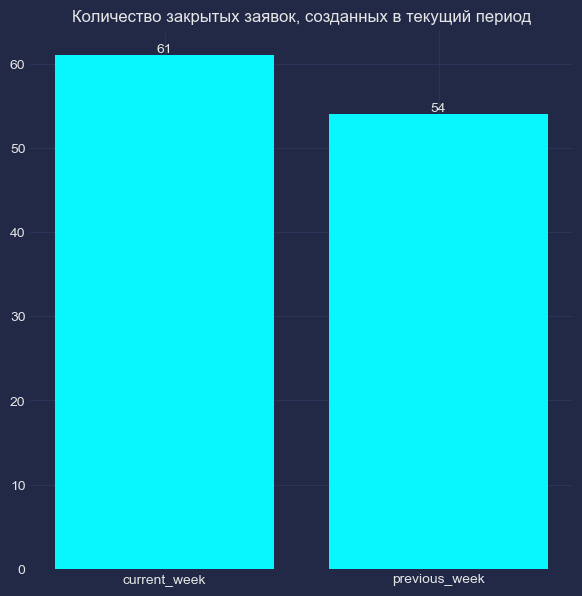

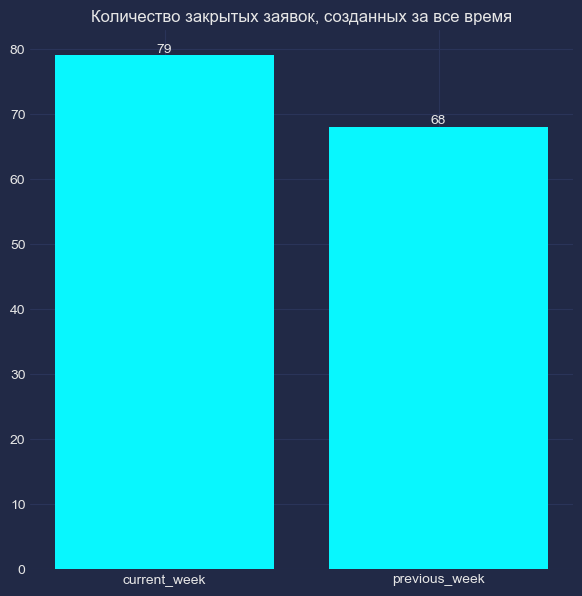

In [38]:
for i,j,k in zip(x,y,titles):
    create_bar(i,j,k)

### Распределение заявок по подразделениям (инициаторам)

Формируем таблицу, в которой подсчитываем количество заявок от каждого подразделения и их долю в общем количестве в процентном соотношении:

In [39]:
def pivot_count(data, column):
    '''
    Функция для формирования сводной таблицы
    Принимает на вход датасет и столбец, который нужно задать в качестве индекса.
    Подсчитывает количество задач и их долю, возвращает таблицу из трех столбцов: столбец, по которому группировали данные,
    количество задач и процент.
    '''
    data_pivot = data.pivot_table(index=column,
                                 values='task_id',
                                 aggfunc='count').rename(columns={'task_id': 'tasks_count'}).reset_index()
    data_pivot['ratio, %'] = ((data_pivot['tasks_count'] / data_pivot['tasks_count'].sum())*100).round(2)        
    return data_pivot

In [40]:
deps_week = pivot_count(week_stat, week_stat['department'])
deps_prev_week = pivot_count(prev_week_stat, prev_week_stat['department'])

Объединяем данные о количестве заявок за текущую и предыдущую неделю в одну таблицу:

In [41]:
deps = deps_week[['department', 'tasks_count']].join(deps_prev_week['tasks_count'],
                                                     how='outer',
                                                     rsuffix = '_prev').set_index('department').fillna(0)
deps['tasks_count_prev'] = deps['tasks_count_prev'].astype('int')
deps['tasks_count'] = deps['tasks_count'].astype('int')

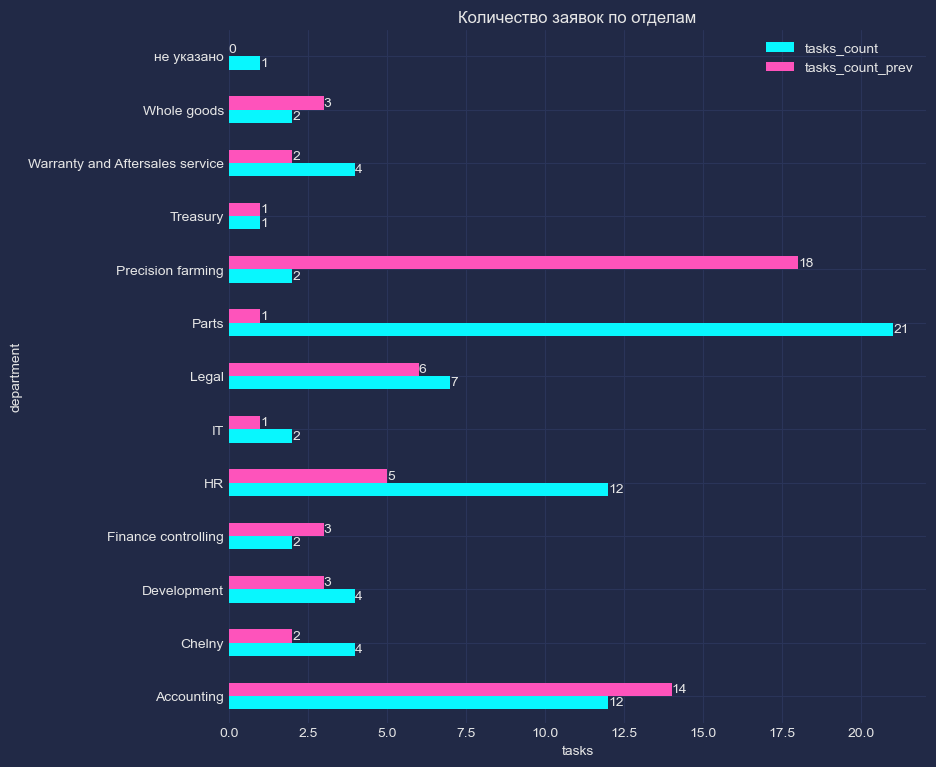

In [42]:
with plt.style.context('cyberpunk'):
    ax = deps.plot.barh(figsize=(9,9))
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    ax.set_xlabel('tasks')
    ax.set_title('Количество заявок по отделам')
    plt.show()

In [43]:
sns.set_palette('mako')

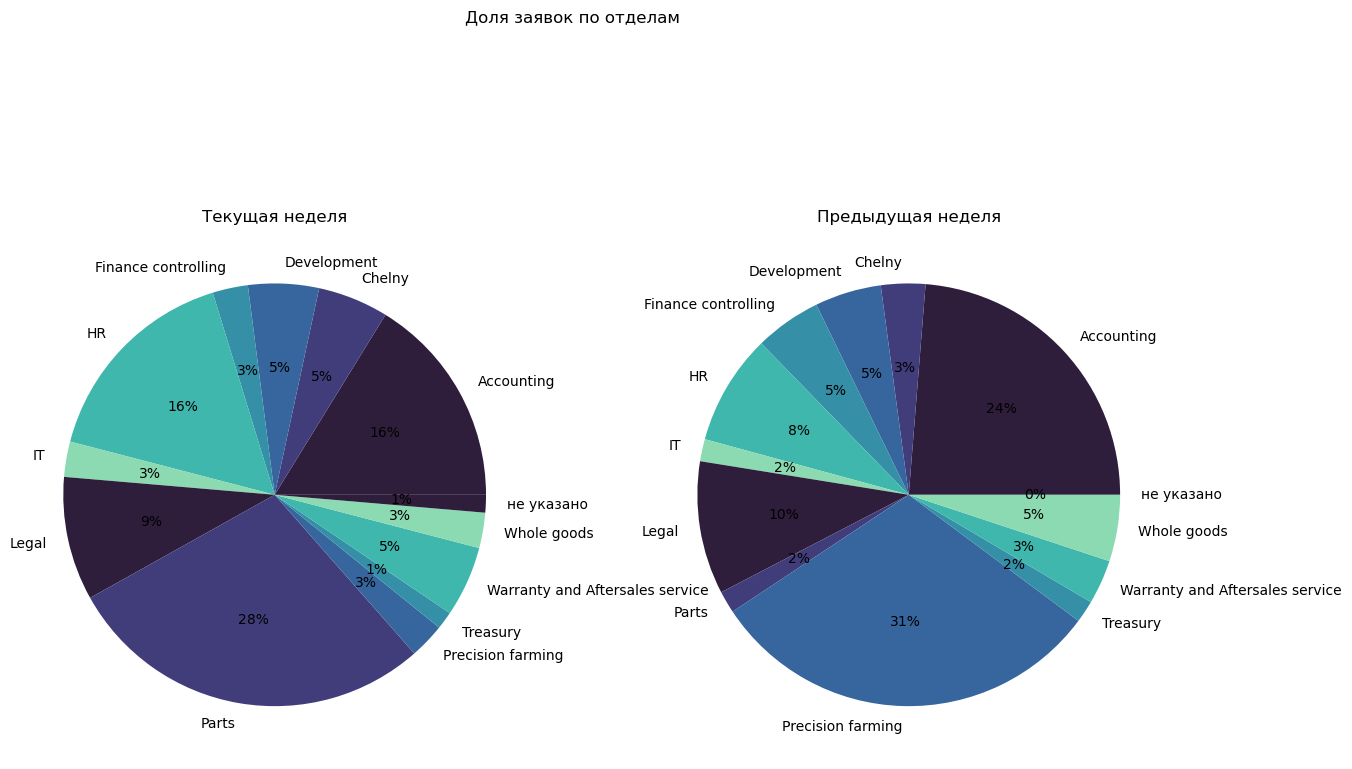

In [44]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle('Доля заявок по отделам')
labels = deps.index
x_1 = deps['tasks_count']
x_2 = deps['tasks_count_prev']
ax_1.pie(x_1, labels = labels, autopct='%.0f%%')
ax_1.set_title('Текущая неделя')
ax_2.pie(x_2, labels = labels, autopct='%.0f%%')
ax_2.set_title('Предыдущая неделя')
plt.show()

### Среднее время решения заявок

Рассчитаем для каждой задачи время, затраченное на ее решение, как разницу между датой создания задачи и датой завершения и добавим эти данные в столбец `processing_time`:

In [45]:
def calc_time(data):
    # получаем разницу между датой завершения и датой создания задачи
    data['processing_time'] = data['close_date'] - data['create_date']
    # переводим полученный результат в минуты
    data['processing_time'] = data['processing_time'].apply(lambda x: x.total_seconds() / 3600).round(2)
    return data

In [46]:
week_stat = calc_time(week_stat).copy()
prev_week_stat = calc_time(prev_week_stat).copy()

Рассчитаем среднее время решения заявок в целом за текущий и предыдущий период:

In [47]:
avg_time_week = week_stat['processing_time'].median()
avg_time_prev = prev_week_stat['processing_time'].median()

In [48]:
x = ['current_week', 'previous_week']
y = [avg_time_week, avg_time_prev]
title = 'Общее среднее время обработки заявок, часов'

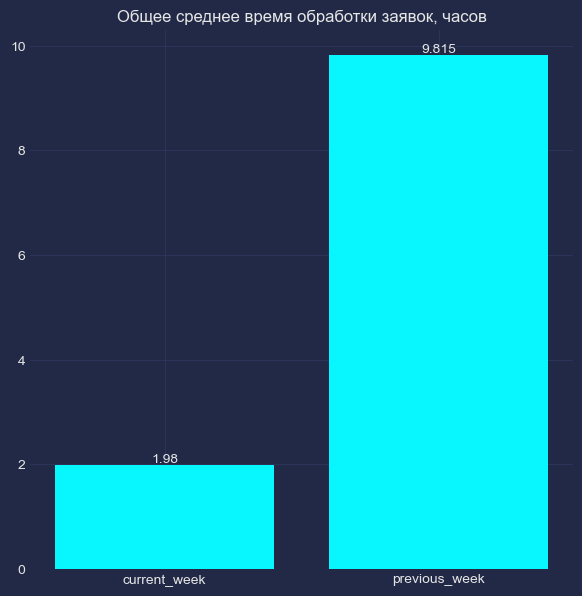

In [49]:
create_bar(x,y,title)

Визуализируем время обработки по типам запросов и подразделениям:

Подсчитываем количество среднее время обработки по типу проблемы:

In [56]:
def draw_median_time(data_1, column_1, data_2, column_2, title):
    '''
    Функция для построения стобчатого графика медианного времени обработки
    Принимает на вход два датасета - за текущий период и предыдущий, а также целевой столбец,
    по которому производится группировка и заголовок графика. Внутри рассчитывается медианное время для каждого датасета,
    Затем они объединяются, и по объединенному датасету строится столбчатая диаграмма.
    Функция возвращает сравнительный график медианного времени за текущий и предыдущий период.
    '''
    week_pivot = data_1.pivot_table(index=column_1,
                                       values='processing_time',
                                       aggfunc='median').reset_index()
    week_pivot.columns = ['index', 'median_time']
    prev_pivot = data_2.pivot_table(index=column_2,
                                    values='processing_time',
                                    aggfunc='median').reset_index()
    prev_pivot.columns = ['index', 'median_time']
    joined_pivot = week_pivot[['index', 'median_time']].join(prev_pivot['median_time'],
                                                     how='outer',
                                                     rsuffix = '_prev').set_index('index').fillna(0)
    display(joined_pivot)
    with plt.style.context('cyberpunk'):
        ax = joined_pivot.plot.barh(figsize=(9,9))
        ax.bar_label(ax.containers[0])
        ax.bar_label(ax.containers[1])
        ax.set_xlabel('median_time')
        ax.set_title(title)
        plt.show()

In [57]:
title = 'Среднее время обработки заявок по типу проблемы, часов'

,median_time,median_time_prev
index,,
1C,18.250,4.855
Запрос доступа,2.755,46.120
ИТ оборудование,0.370,72.040
Мобильная связь,24.980,99.080
Офисные программы,0.690,1.760
не указано,0.130,12.955


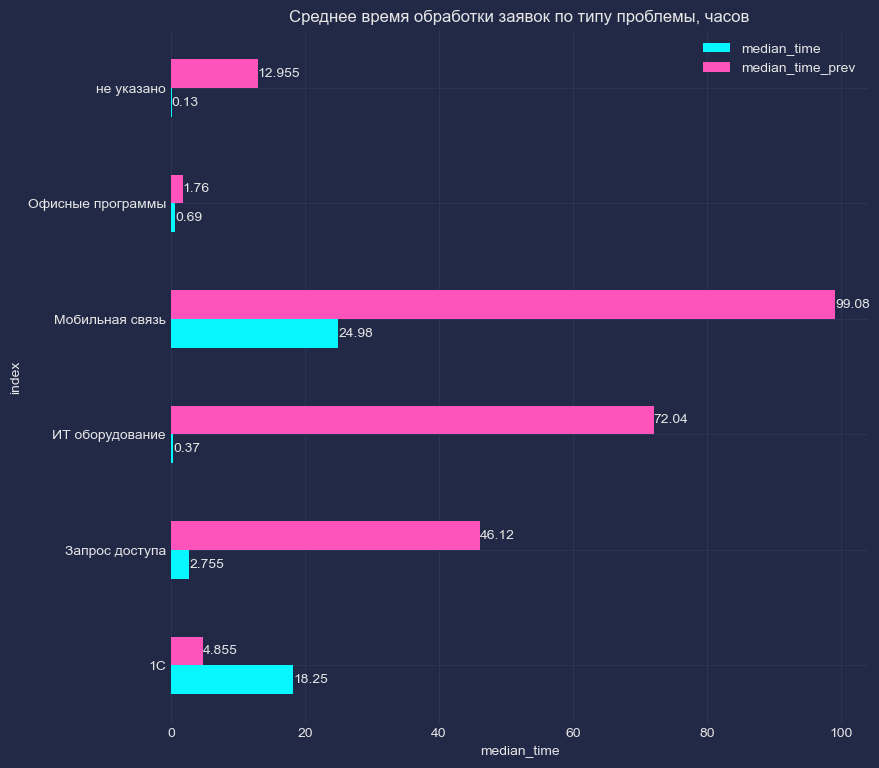

In [58]:
draw_median_time(week_stat, week_stat['problem'], prev_week_stat, prev_week_stat['problem'], title)

И по подразделениям:

In [59]:
title = 'Среднее время обработки заявок по подразделениям, часов'

,median_time,median_time_prev
index,,
Accounting,0.400,11.485
Chelny,1.225,1.905
Development,1.110,93.780
Finance controlling,54.870,10.685
HR,0.390,72.040
IT,1.330,2.390
Legal,69.410,25.170
Parts,3.130,4.870
Precision farming,0.290,2.670


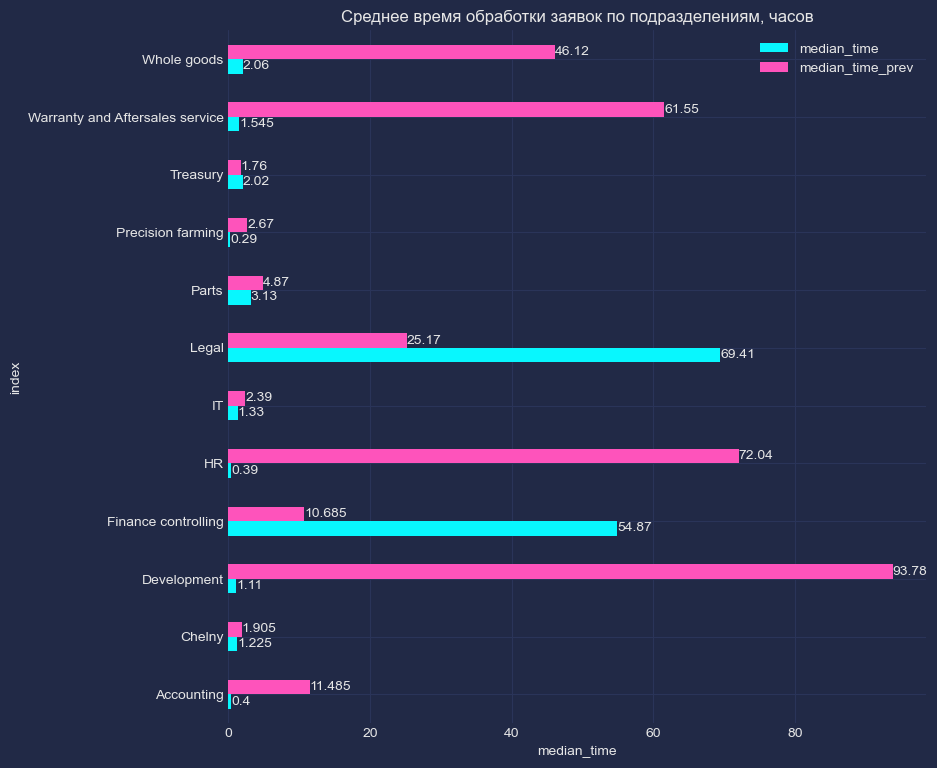

In [60]:
draw_median_time(week_stat, week_stat['department'], prev_week_stat, prev_week_stat['department'], title)

### Распределение баз 1С

Визуализируем данные по количеству заявок:

In [61]:
week_base = pivot_count(week_stat, week_stat['base'])
prev_week_base = pivot_count(prev_week_stat, prev_week_stat['base'])

In [63]:
bases = week_base[['base', 'tasks_count']].join(prev_week_base['tasks_count'],
                                                     how='outer',
                                                     rsuffix = '_prev').set_index('base').fillna(0)

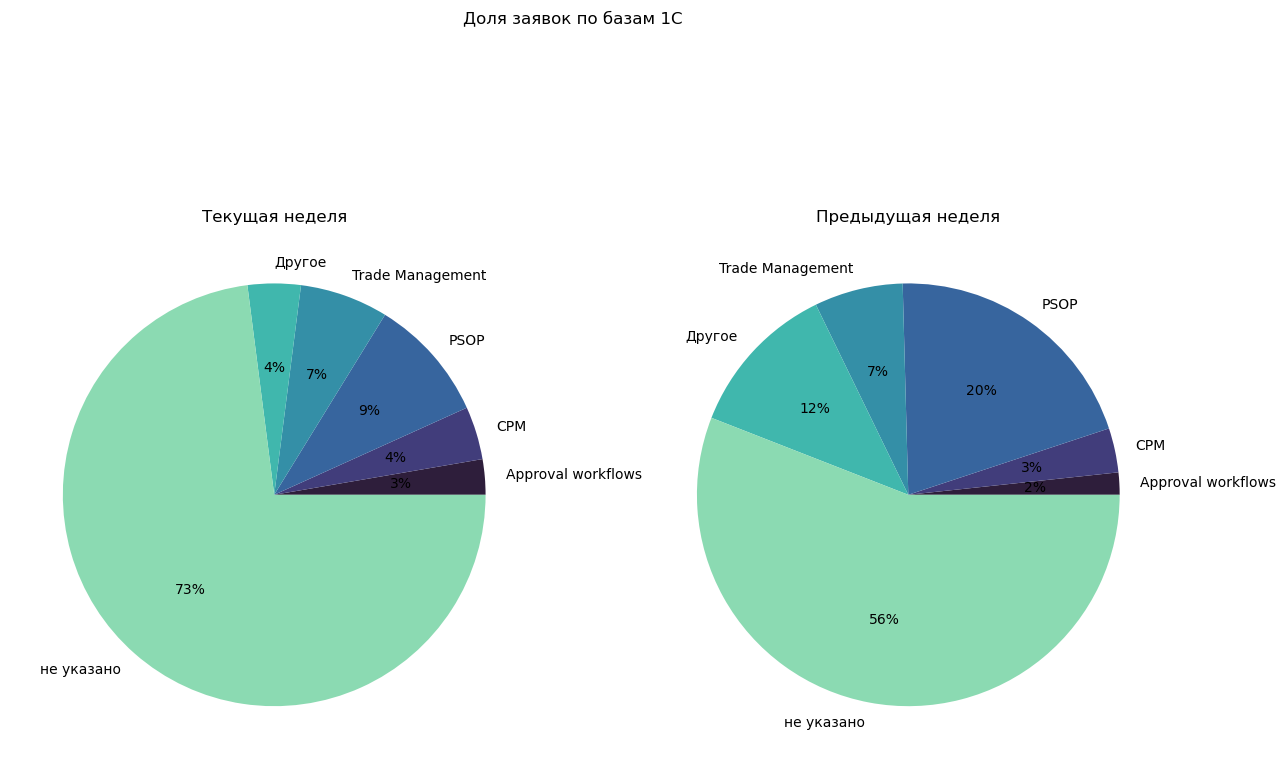

In [64]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle('Доля заявок по базам 1С')
labels = bases.index
x_1 = bases['tasks_count']
x_2 = bases['tasks_count_prev']
ax_1.pie(x_1, labels = labels, autopct='%.0f%%')
ax_1.set_title('Текущая неделя')
ax_2.pie(x_2, labels = labels, autopct='%.0f%%')
ax_2.set_title('Предыдущая неделя')
plt.show()

И по времени обработки:

In [65]:
title = 'Среднее время обработки заявок по базам 1С, часов'

,median_time,median_time_prev
index,,
Approval workflows,1.375,221.980
CPM,40.570,2.005
PSOP,5.090,3.260
Trade Management,36.560,21.260
Другое,0.610,11.650
не указано,0.985,12.960


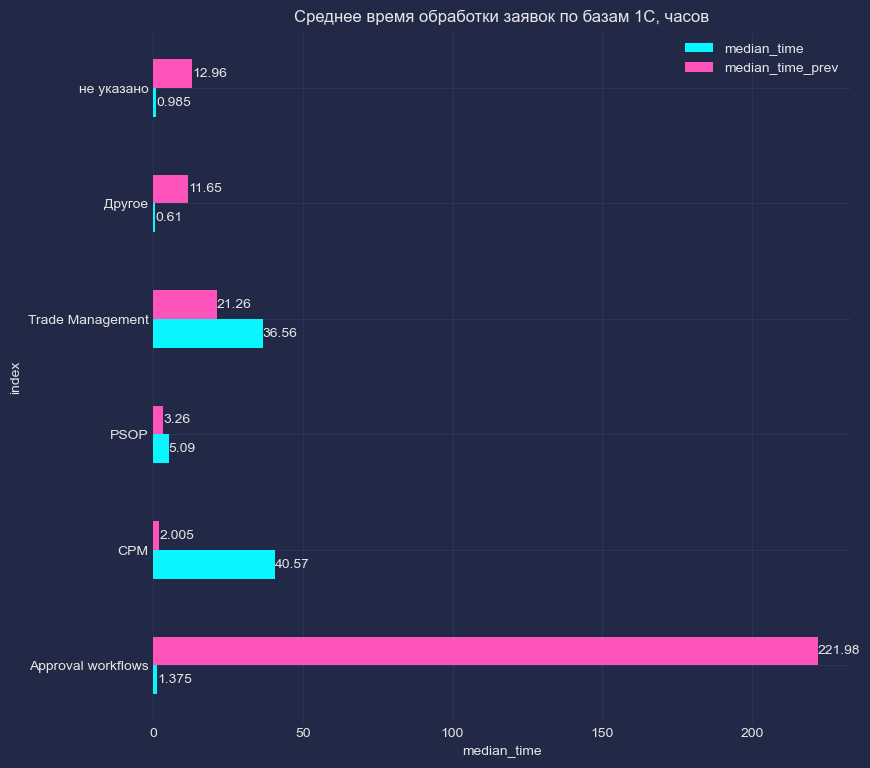

In [66]:
draw_median_time(week_stat, week_stat['base'], prev_week_stat, prev_week_stat['base'], title)